In [1]:
import os
import json

import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib widget
plt.close("all")

basedir = "../../data/InterHand2.6M_30fps/"
split = "train"
capture_id = 0
seq_name = "0051_dinosaur"
data_root = os.path.join(basedir, "images", split, f"Capture{capture_id}", seq_name)

hand_type = "right"
frame_index = 0
camera_index = 10

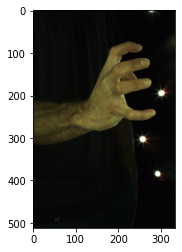

In [2]:
%matplotlib inline
annot = np.load(os.path.join(data_root, "annots.npy"), allow_pickle=True).item()
img_path = annot["ims"][frame_index]["ims"][camera_index]
img = cv2.imread(os.path.join(data_root, img_path))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
%matplotlib widget

## world coordinates in meter

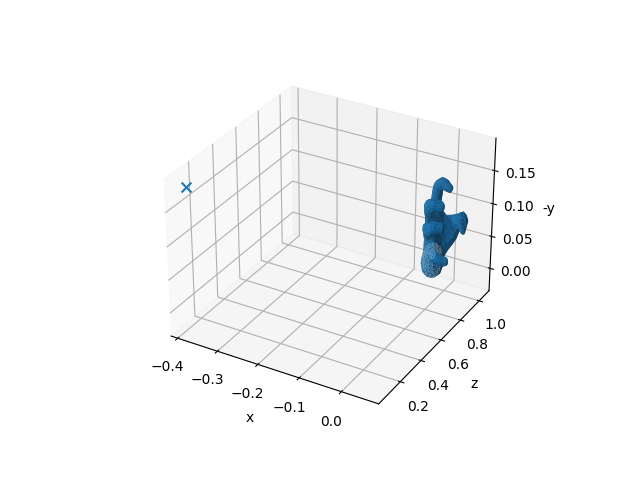

In [3]:
frame_idx = int(img_path.split("/")[-1][5:-4])
cam_id = img_path.split("/")[0][3:]
K = np.array(annot["cams"]["K"][cam_id])  # 3x3
R = np.array(annot["cams"]["R"][cam_id])  # 3x3
T = np.array(annot["cams"]["T"][cam_id]) / 1000  # mm to m  3x1
mesh = np.load(os.path.join(data_root, "vertices", hand_type, f"{frame_idx}.npy"))  # 778x3

plt.close(1)
fig = plt.figure(1)
ax = fig.add_subplot(111, projection="3d")
ax.set_xlabel("x")
ax.set_ylabel("z")
ax.set_zlabel("-y")
# for vertex in mesh:
#     ax.scatter(vertex[0], vertex[2], -vertex[1], color="black", marker="o", s=5)
faces = np.load(os.path.join(data_root, "lbs", hand_type, "faces.npy"))
ax.plot_trisurf(mesh[:, 0], mesh[:, 2], -mesh[:, 1], triangles=faces)

campos = -np.dot(np.linalg.inv(R), T)
ax.scatter(campos[0, :], campos[2, :], -campos[1, :], marker="x", s=50)

plt.show()

## camera coordinates in meter

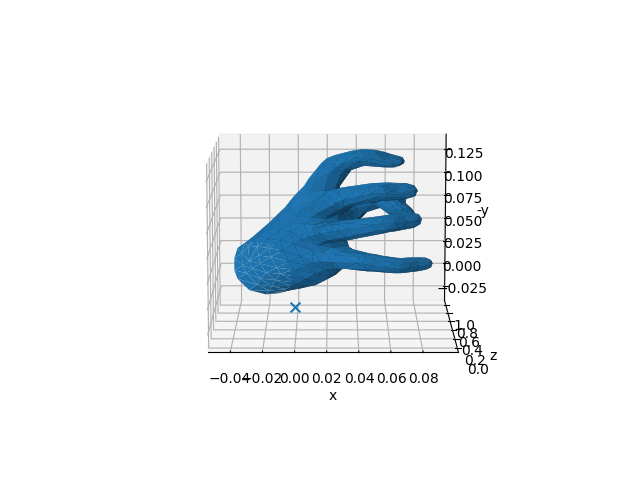

In [4]:
mesh_cam = np.dot(mesh, R.T) + T.T

plt.close(2)
fig = plt.figure(2)
ax = fig.add_subplot(111, projection="3d")
ax.set_xlabel("x")
ax.set_ylabel("z")
ax.set_zlabel("-y")
ax.plot_trisurf(mesh_cam[:, 0], mesh_cam[:, 2], -mesh_cam[:, 1], triangles=faces)
ax.view_init(elev=10, azim=-90)

campos_cam = np.dot(R, campos) + T
ax.scatter(campos_cam[0, :], campos_cam[2, :], -campos_cam[1, :], marker="x", s=50)

plt.show()

## pixel coordinates

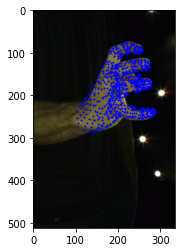

In [5]:
pixel = np.dot(K, mesh_cam.T)
pixel = (pixel[0:2, :] / pixel[2:, :]).T

%matplotlib inline
plt.close(3)
fig = plt.figure(3)
ax = fig.add_subplot(111)
ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

ax.scatter(pixel[:, 0], pixel[:, 1], c="blue", s=1)
ax.set_xlim([0, 334])
ax.set_ylim([0, 512])
ax.invert_yaxis()
ax.set_aspect(1)

plt.show()
%matplotlib widget

## pose coordinates in meter

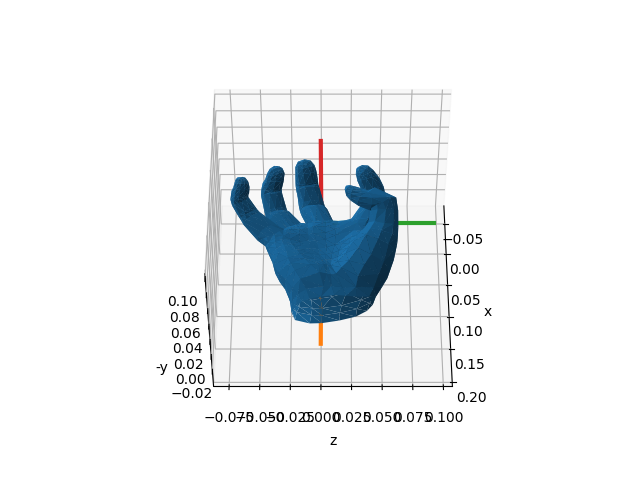

In [6]:
params = np.load(os.path.join(data_root, "params", hand_type, f"{frame_idx}.npy"), allow_pickle=True).item()
Rh = np.array(params["Rh"])
Th = np.array(params["Th"])
Rh_matrix = cv2.Rodrigues(params["Rh"][0])[0]
mesh_pose = np.dot(mesh - Th, Rh_matrix)

plt.close(4)
fig = plt.figure(4)
ax = fig.add_subplot(111, projection="3d")
ax.set_xlabel("x")
ax.set_ylabel("z")
ax.set_zlabel("-y")
ax.plot_trisurf(mesh_pose[:, 0], mesh_pose[:, 2], -mesh_pose[:, 1], triangles=faces)
ax.view_init(elev=50, azim=0)

# ax.scatter(0, 0, 0, marker="o", s=2000, c="black")
ax.plot([0, mesh_pose[:, 0].max() * 1.5], [0, 0], [0, 0], linewidth=3)
ax.plot([0, 0], [0, mesh_pose[:, 2].max() * 1.5], [0, 0], linewidth=3)
ax.plot([0, 0], [0, 0], [0, (-mesh_pose[:, 1]).max() * 1.5], linewidth=3)

# campos_pose = np.dot(T.reshape(-1, 3) - Th, Rh_matrix)[0]
# ax.scatter(campos_pose[0], campos_pose[2], -campos_pose[1], marker="x", s=50)

plt.show()

## T-pose joints & mesh (pose coordinates) in meter

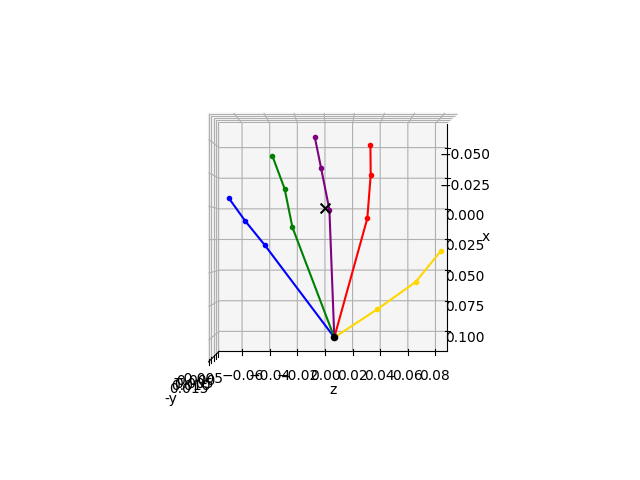

In [7]:
joints = np.load(os.path.join(data_root, "lbs", hand_type, "joints.npy"), allow_pickle=True)

plt.close(5)
fig = plt.figure(5)
ax = fig.add_subplot(111, projection="3d")
ax.set_xlabel("x")
ax.set_ylabel("z")
ax.set_zlabel("-y")
# ax.scatter(joints[:, 0], joints[:, 2], -joints[:, 1], marker="o")
C = ["red", "purple", "blue", "green", "gold", "black"]
for i, r in enumerate([np.arange(1, 4), np.arange(4, 7), np.arange(7, 10), np.arange(10, 13), np.arange(13, 16)]):
    r_ = np.append(0, r)
    ax.plot(xs=joints[r_, 0], ys=joints[r_, 2], zs=-joints[r_, 1], color=C[i], marker="o", markersize=3)
ax.scatter(joints[0, 0], joints[0, 2], -joints[0, 1], color=C[-1], marker="o", s=20)
ax.view_init(elev=90, azim=0)

ax.scatter(0, 0, 0, marker="x", s=50, c="black")

plt.show()

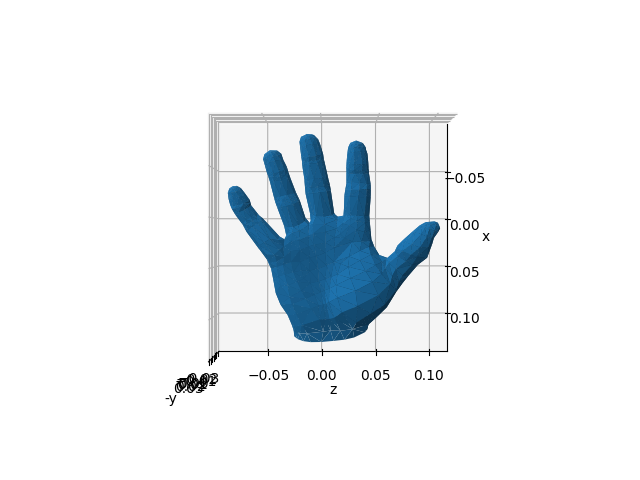

In [8]:
tmesh = np.load(os.path.join(data_root, "lbs", hand_type, "tvertices.npy"))

plt.close(6)
fig = plt.figure(6)
ax = fig.add_subplot(111, projection="3d")
ax.set_xlabel("x")
ax.set_ylabel("z")
ax.set_zlabel("-y")
ax.plot_trisurf(tmesh[:, 0], tmesh[:, 2], -tmesh[:, 1], triangles=faces)
ax.view_init(elev=90, azim=0)
plt.show()

## Novel Views Demo

In [9]:
# load joint 3D
split = "train"
with open(basedir + "annotations/" + split + "/InterHand2.6M_" + split + "_joint_3d.json") as f:
    joint = json.load(f)
test_joint_valid = joint["0"]["563"]["joint_valid"]
test_joint = []
for i, j in enumerate(joint["0"]["563"]["world_coord"]):
    if test_joint_valid[i][0] == 1.0:
        test_joint.append(j)
del joint
test_joint = np.array(test_joint, dtype=np.float32).reshape(-1, 3)


def plot_joint(joint, ax):
    # for point_id, point in enumerate(test_joint):
    #     ax.scatter(point[0], point[2], -point[1], color="black", marker="o")
    # ax.text(point[0], point[2], -point[1], point_id)
    C = ["red", "purple", "blue", "green", "gold", "black"]
    for i, r in enumerate([np.arange(0, 4), np.arange(4, 8), np.arange(8, 12), np.arange(12, 16), np.arange(16, 20)]):
        r_ = np.append(r, -1)
        ax.plot(xs=joint[r_, 0], ys=joint[r_, 2], zs=-joint[r_, 1], color=C[i], marker="o", markersize=3)
    ax.scatter(joint[-1, 0], joint[-1, 2], -joint[-1, 1], color=C[-1], marker="o", s=20)

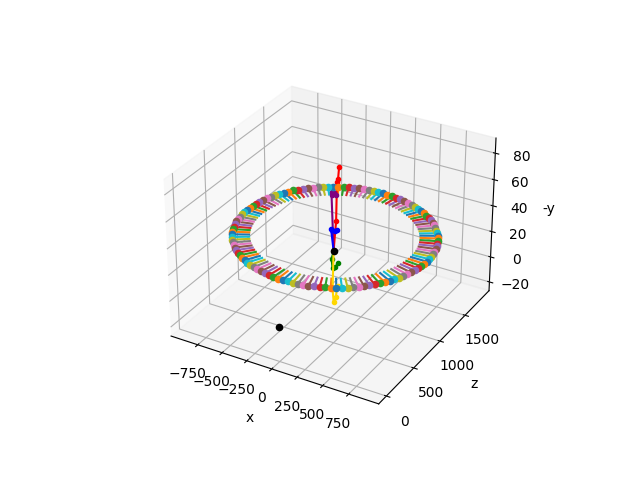

In [10]:
poses = np.load("novel_cams.npy")
is_spheric = True
if is_spheric:
    poses[:, 1, -1] = 0
    poses[:, :, -1] += np.mean(test_joint, axis=0)
else:
    poses[:, :, -1] += np.array([0, np.mean(test_joint, axis=0)[1], 0])

plt.close(7)
fig = plt.figure(7)
ax = fig.add_subplot(111, projection="3d")
ax.set_xlabel("x")
ax.set_ylabel("z")
ax.set_zlabel("-y")

for pose in poses:
    campos = pose[:, -1]
    end = np.array([0, 0, 150, 1]).reshape(4, 1)
    end = np.dot(pose, end).reshape(-1)
    ray = np.stack([campos, end], axis=0)
    ax.scatter(campos[0], campos[2], -campos[1])
    ax.plot(xs=ray[:, 0], ys=ray[:, 2], zs=-ray[:, 1])
ax.scatter(0, 0, 0, c="black")

plot_joint(test_joint, ax)